NIfTI (Neuroimaging Informatics Technology Initiative) is a common file format for storing neuroimaging data.
It allows to:
- store multi-dimensional arrays (3D or 4D).
- store header information about voxel dimensions, data type, and spatial orientation.

It is usually saved in `.nii` or compressed `.nii.gz` extensions.

Let's install the needed packages

In [1]:
# %%
# !pip install nibabel nilearn

And download some dataset as example -> IXI

In [2]:
# If for personal interest you want to download the unprocessed IXI...

# !wget -nc http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar -O ../data/IXI-T1.tar
# !mkdir ../data/IXI
# !wget -nc http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI.xls -O ../data/IXI/IXI.xls
# !tar -xvf ../data/IXI-T1.tar -C ../data/IXI

In [3]:
# We download instead a preprocessed version (will be explained...)
# !curl -L -o -z ../data/preprocessed-ixi-dataset-with-fs8.zip https://www.kaggle.com/api/v1/datasets/download/kingpowa/preprocessed-ixi-dataset-with-fs8
# !unzip -n ../data/preprocessed-ixi-dataset-with-fs8.zip -d ../data
# !mv -v ../data/T1_Preprocessed_IXI/IXI/* ../data/IXI
# !rm -rf ../data/preprocessed-ixi-dataset-with-fs8.zip
# !rm -rf ../data/T1_Preprocessed_IXI

In [4]:
## Imports
import os
# Brain manip
import nibabel as nib # <- Library for handling nifti files
import numpy as np
from nilearn import image
from nilearn import masking
import nilearn
# Plotting 
from nilearn import plotting
import matplotlib.pyplot as plt
# Visualize
from nibabel.freesurfer.io import read_morph_data
import pandas as pd

Let's visualize an example of a nifti file from the IXI files

In [6]:
example_image = "../data/example_data/sub-IXI002_acq-Philips-1.5T_T1w.nii.gz"
brain_nii = nib.load(example_image)
header = brain_nii.header

print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 150   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.        0.9375    0.9375    1.199997  0.        0.        0.
  0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'MR'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.468175
quatern_c       : -0.5299171
quatern_d       : -0.468175
qoffset_x       : -88.63989
qoffset_y       : 116.

In [7]:
brain = brain_nii.get_fdata()
print(f"Data shape: {brain.shape}")
print(f"Voxel dimensions: {header.get_zooms()}") # This how relates each voxels in mm in real life

Data shape: (256, 256, 150)
Voxel dimensions: (0.9375, 0.9375, 1.199997)


We can quickly visualize the brain via `matplotlib`...

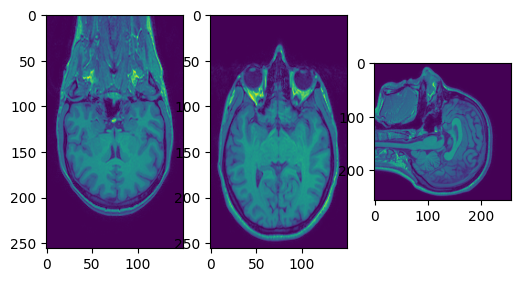

In [8]:
fig, ax = plt.subplots(1,3,figsize=(6,18))
plot_points = [x//2 for x in brain.shape[-3:]]
ax[0].imshow(brain[plot_points[0]])
ax[1].imshow(brain[:,plot_points[1]])
ax[2].imshow(brain[:,:,plot_points[2]])
plt.show()

As you can see, plotting with simple library does not take into account the affine properties of the brain
`nilearn` allows us to overcome this problem as it is specialised for brain visualisation.

/tmp/ipykernel_1294279/206455878.py:1: UserWarning: Casting data from int32 to float32
  plotting.plot_anat(brain_nii,


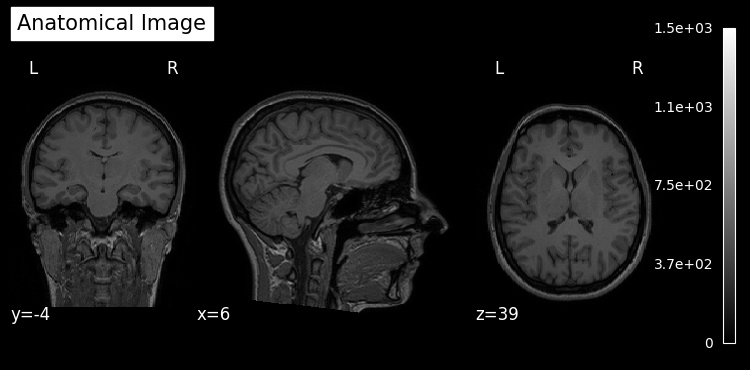

In [9]:
plotting.plot_anat(brain_nii, 
                   title='Anatomical Image', 
                   display_mode='ortho', # <-- display all the slices orientations
                   draw_cross=False) # <-- Do not draw a cross showing the cut      
plotting.show()

In order to execute many pipelines in the ML domain, it is important to preprocess this type of data
An usual pipeline consists in aligning the brain to known template. It is a digital‐image reference that represents the average of the brain. The MNI152 is a very well known brain template example. Let's visualize it.

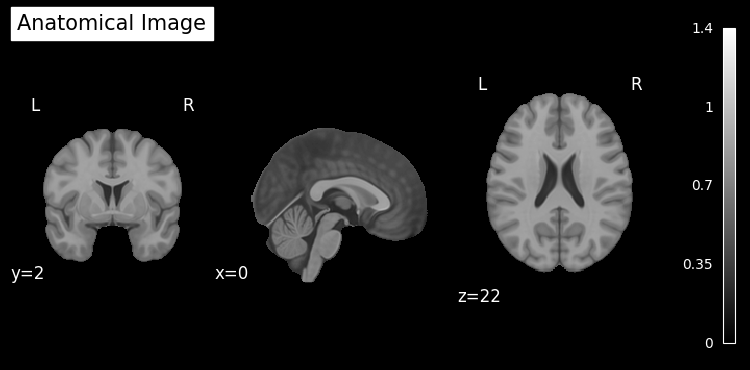

In [10]:
# The atlas can be obtained via nilearn
mni152_template = nilearn.datasets.load_mni152_template()
plotting.plot_anat(mni152_template, 
                   title='Anatomical Image', 
                   display_mode='ortho',
                   draw_cross=False)
plotting.show()

In many ML pipelines, the images are "registered" to this template.
Registering a brain means finding and applying a spatial transform that warps the MRI to a predefined coordinate space. In other words, we modify the spatial position (or structure) of the brain so that it is aligned as the known template.
This is done because in ML having a structure input is much more beneficial for many algorithms, providing fewer variables to learn.

`nilearn` allows to execute easily a "linear" registration. A linear registration simply performs an affine transformation (i.e. rotation, scaling...), without modifying the structure of the tissues. This can be useful if we want to keep the structure of the brain intact for keeping individual differences.
This also allows to adapt the spatial meaning of the pixels of the two brains.

In [11]:
# As we see, the zooms of the mni152_template are different
mni152_template.header.get_zooms()

(1.0, 1.0, 1.0)

In [12]:
registered_brain_nii = image.resample_to_img(
    source_img=brain_nii,
    target_img=mni152_template,
    force_resample=True,
    interpolation='continuous' # we do a cubic interpolation
)

/tmp/ipykernel_1294279/3081064025.py:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  registered_brain_nii = image.resample_to_img(
/tmp/ipykernel_1294279/3081064025.py:1: UserWarning: Casting data from int16 to float32
  registered_brain_nii = image.resample_to_img(


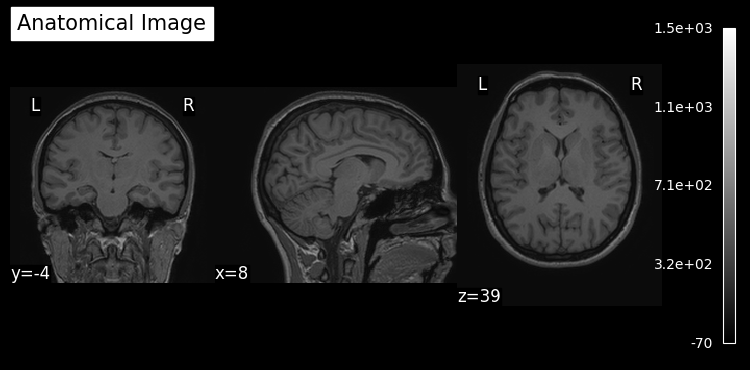

In [13]:
# It is now aligned to the same orientation of the template
plotting.plot_anat(registered_brain_nii, 
                   title='Anatomical Image', 
                   display_mode='ortho',
                   draw_cross=False) 
plotting.show()

After registration, usually a skullstripping operation is executed. Skullstripping is an operation that allows to remove any elements from the original image that is not belonging to the brain tissue. For instance, it removes the skull or other elements. This allows to better process the brain for other tasks.
Skullstripping is a complex operation, usually performed with specialised tools.
`nilearn` provides a basic function we can use as an example

In [14]:
brain_mask_estimation_nii = masking.compute_brain_mask(registered_brain_nii)
brain_skullstripped_nii = image.math_img("img * mask", img=registered_brain_nii, mask=brain_mask_estimation_nii)

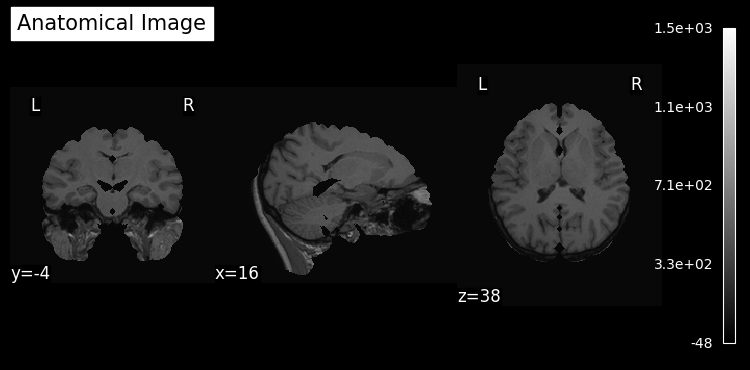

In [15]:
plotting.plot_anat(brain_skullstripped_nii, 
                   title='Anatomical Image', 
                   display_mode='ortho',
                   draw_cross=False) 
plotting.show()

As you see, the results is _extremely_ poor. This is because many possible problems are present in the images
- a very aggressive bias field (slow intensity drift)
- low contrast
- ecc...
`nilearn` is also not very specialised on this.

A very well known skullstripping program is Freesurfer. It is an open-source software which is also used for other tasks, such as cortical thickness calculation and estimation, volumetric seg., ecc...

The repo contains a preprocessd set of IXI files via `freesurfer`
Let's see the difference with what we have done here.

First, let's analyze the csv

In [16]:
masterfile_path = "../data/IXI/subjects.csv"
masterfile = pd.read_csv(masterfile_path, index_col=0)
masterfile.head(5)

,age,sex,scanner,site,diagnosis,dataset_name,subject_key,session,run,registered_mni
subject_id,,,,,,,,,,
IXI002,35.80,Female,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,IXI002_IXI,1,1,sub-IXI002/ses-1/run-1/anat/sub-IXI002_acq-Phi...
IXI012,38.78,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI012_IXI,1,1,sub-IXI012/ses-1/run-1/anat/sub-IXI012_acq-Phi...
IXI013,46.71,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI013_IXI,1,1,sub-IXI013/ses-1/run-1/anat/sub-IXI013_acq-Phi...
IXI014,34.24,Female,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI014_IXI,1,1,sub-IXI014/ses-1/run-1/anat/sub-IXI014_acq-Phi...
IXI015,24.28,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI015_IXI,1,1,sub-IXI015/ses-1/run-1/anat/sub-IXI015_acq-Phi...


In [17]:
masterfile.describe()

,age,session,run
count,579.000000,579.0,579.0
mean,47.002055,1.0,1.0
std,18.432171,0.0,0.0
min,-1.000000,1.0,1.0
25%,32.610000,1.0,1.0
50%,47.070000,1.0,1.0
75%,62.010000,1.0,1.0
max,86.320000,1.0,1.0


We clearly have some candidates with missing age (-1). We remove it

In [18]:
masterfile = masterfile[masterfile["age"] != -1]

Let's visualize the skullstripped brain

In [31]:
BASE_PATH = "../data/IXI"
random_brain_path = os.path.join(BASE_PATH, masterfile.sample(frac=1.)["registered_mni"].values[0][:-3]) # added to remove gz
random_brain = nib.load(random_brain_path)
print(f"Data shape: {random_brain.shape}")
print(f"Voxel dimensions: {random_brain.header.get_zooms()}") # This how relates each voxels in mm in real life

Data shape: (182, 218, 182)
Voxel dimensions: (1.0, 1.0, 1.0)


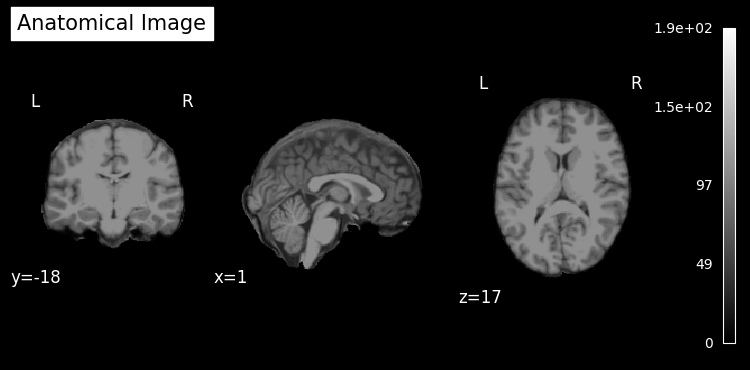

In [32]:
plotting.plot_anat(random_brain, 
                   title='Anatomical Image', 
                   display_mode='ortho', # <-- display all the slices orientations
                   draw_cross=False) # <-- Do not draw a cross showing the cut      
plotting.show()

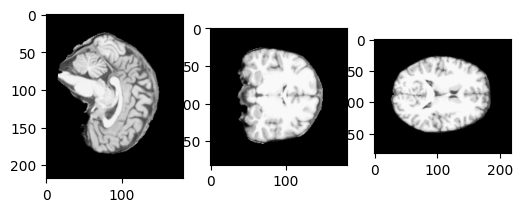

In [36]:
# For comparision, let's see normal visualizaiton method
random_brain_data = random_brain.get_fdata(dtype=np.float32)
fig, ax = plt.subplots(1,3,figsize=(6,18))
plot_points = [x//2 for x in random_brain_data.shape[-3:]]
ax[0].imshow(random_brain_data[plot_points[0]], cmap="Greys_r")
ax[1].imshow(random_brain_data[:,plot_points[1]], cmap="Greys_r")
ax[2].imshow(random_brain_data[:,:,plot_points[2]], cmap="Greys_r")
plt.show()

# EDA

Now, let's study the distribution age of our dataset

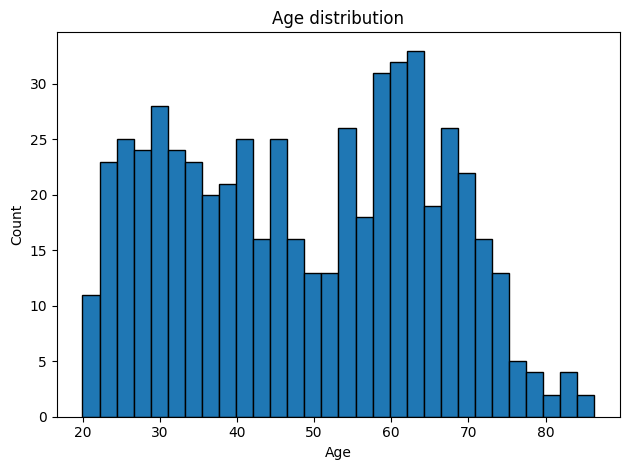

In [45]:
# Let's plot the age distribution to better visualize it
def plot_age_distribution_by(by=None):
    plt.figure()
    if by is None:
        plt.hist(masterfile['age'], bins=30, edgecolor='black')
        plt.title('Age distribution')
    else:
        groups = masterfile[by].unique()
        for g in groups:
            subset = masterfile[masterfile[by] == g]
            plt.hist(subset['age'], bins=30, alpha=0.5, label=str(g))
        plt.title(f'Age distribution by {by}')
        plt.legend()
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_age_distribution_by()

It seems the IXI dataset covers a good amount of age range. Let's see per scanner

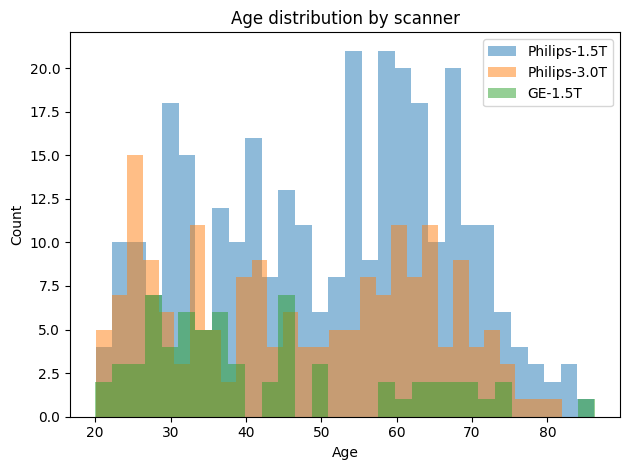

In [46]:
plot_age_distribution_by("scanner")

The study here show that each scanner covers a good amount of age distribution, with the GE-1.5T having some missing ages. Let's keep this in mind.

The masterfile provide also a thickness. The thickness is the estimated surface cortical thickness per voxel extracted via `freesurfer`. Let's visualize it for a generic candidate.

In [47]:
example_thickness_file = "../data/example_data/sub-IXI002_acq-Philips-1.5T_hemi-L_thickness"
lh_thickness_values = read_morph_data(example_thickness_file)
lh_thickness_values.shape

(131103,)

These are the cortical thickness values of the left emisphere per-vertex map.
Cortical Thickness values are very useful since they provide a numeric quantity that is more structure than plain images/volumes of the brain.

However, there is as you can see an extremely high dimensionality. We can reduce this values to a per-region average.
In the file I provided, you can find the already averaged annotations (`../notebooks/additional/get_averaged_regions.ipynb` gives you a glimpse of how this can be done).

In [48]:
thickness_df = pd.read_csv("../data/IXI/thickness.csv")
thickness_df

,subject_id,hemi,region,mean_thickness_weighted,mean_thickness_simple
0,IXI002,lh,label_-1,0.000369,0.000338
1,IXI002,lh,label_2,2.767575,2.609781
2,IXI002,lh,label_3,2.828643,2.690581
3,IXI002,lh,label_5,2.019888,2.020947
4,IXI002,lh,label_6,2.712761,2.636525
...,...,...,...,...,...
37063,IXI662,rh,label_29,2.120859,2.023058
37064,IXI662,rh,label_30,2.965944,2.796967
37065,IXI662,rh,label_31,2.508402,2.370133
37066,IXI662,rh,label_34,2.354042,2.350365


As you can see, we have aggregated the values per region, which will allow us an easier analysis in further steps of our lessons.